In [ ]:
# default_exp models.TSiTPlus

# TSiT & InceptionTSiT

> These are PyTorch implementations created by Ignacio Oguiza (timeseriesAI@gmail.com) based on ViT (Vision Transformer)
     
Reference: 

     Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020).
     An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

     This implementation is a modified version of Vision Transformer that is part of the grat timm library
     (https://github.com/rwightman/pytorch-image-models/blob/72b227dcf57c0c62291673b96bdc06576bb90457/timm/models/vision_transformer.py)

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.InceptionTimePlus import InceptionBlockPlus
from typing import Callable

In [ ]:
# export
class _TSiTEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers:int=6, attn_dropout:float=0, dropout:float=0, drop_path_rate:float=0., 
                 mlp_ratio:int=1, qkv_bias:bool=True, act:str='reglu', pre_norm:bool=False):
        super().__init__()
        
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.layers = nn.ModuleList([])
        for i in range(n_layers):
            self.layers.append(nn.ModuleList([
                MultiheadAttention(d_model, n_heads, attn_dropout=attn_dropout, proj_dropout=dropout, qkv_bias=qkv_bias), nn.LayerNorm(d_model),
                PositionwiseFeedForward(d_model, dropout=dropout, act=act, mlp_ratio=mlp_ratio), nn.LayerNorm(d_model),
                # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
                DropPath(dpr[i]) if dpr[i] != 0 else nn.Identity(),
                # nn.Dropout(drop_path_rate) if drop_path_rate != 0 else nn.Identity()
            ]))
        self.pre_norm = pre_norm
        self.norm = nn.LayerNorm(d_model) if self.pre_norm else nn.Identity()

    def forward(self, x):
        for i, (mha, attn_norm, pwff, ff_norm, drop_path) in enumerate(self.layers):
            if self.pre_norm:
                x = drop_path(mha(attn_norm(x))[0]) + x
                x = drop_path(pwff(ff_norm(x))) + x
            else:
                x = attn_norm(drop_path(mha(x)[0]) + x)
                x = ff_norm(drop_path(pwff(x)) + x)
        
        x = self.norm(x)
        return x


class _TSiTBackbone(Module):
    def __init__(self, c_in:int, seq_len:int, n_layers:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, qkv_bias:bool=True, dropout:float=0., attn_dropout:float=0,drop_path_rate:float=0., 
                 mlp_ratio:int=1, pre_norm:bool=False, use_token:bool=True, ks:Optional[int]=None, maxpool:bool=True, 
                 feature_extractor:Optional[Callable]=None, verbose:bool=False):

        self.feature_extractor = nn.Identity()
        if feature_extractor is not None:
            xb = torch.randn(1, c_in, seq_len)
            ori_c_in, ori_seq_len = c_in, seq_len
            if not isinstance(feature_extractor, nn.Module): feature_extractor = feature_extractor(c_in, d_model)
            else: feature_extractor = feature_extractor
            with torch.no_grad():
                # NOTE Most reliable way of determining output dims is to run forward pass
                training = feature_extractor.training
                if training:
                    feature_extractor.eval()
                c_in, seq_len = feature_extractor(xb).shape[1:]
                feature_extractor.train(training)
            pv(f'feature_extractor: (?, {ori_c_in}, {ori_seq_len}) --> (?, {c_in}, {seq_len})', verbose=verbose)
            self.feature_extractor = feature_extractor
        
        if ks is not None: 
            self.to_embedding = nn.Sequential(MultiConcatConv1d(c_in, d_model, kss=ks, maxpool=maxpool),Transpose(1,2))
        else: 
            self.to_embedding = nn.Sequential(Conv1d(c_in, d_model, 1),Transpose(1,2))
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len + use_token, d_model))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.use_token = use_token
        self.pos_dropout = nn.Dropout(dropout)

        self.encoder = _TSiTEncoder(d_model, n_heads, n_layers=n_layers, qkv_bias=qkv_bias, attn_dropout=attn_dropout, dropout=dropout,
                                    mlp_ratio=mlp_ratio, drop_path_rate=drop_path_rate, act=act, pre_norm=pre_norm)

    def forward(self, x):

        # apply feature_extractor module if exists
        x = self.feature_extractor(x)
        
        # embedding
        x = self.to_embedding(x)
        if self.use_token:
            x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_dropout(x + self.pos_embedding)

        x = self.encoder(x)

        x = x.transpose(1,2)
        return x

In [ ]:
#exports
class TSiTPlus(nn.Sequential):
    """Time series transformer model based on ViT (Vision Transformer):

    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020).
    An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

    This implementation is a modified version of Vision Transformer that is part of the grat timm library
    (https://github.com/rwightman/pytorch-image-models/blob/72b227dcf57c0c62291673b96bdc06576bb90457/timm/models/vision_transformer.py)
    """


    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, attn_dropout:float=0, dropout:float=0., drop_path_rate:float=0., mlp_ratio:int=1,
                 qkv_bias:bool=True, pre_norm:bool=False, use_token:bool=True, fc_dropout:float=0., bn:bool=False, y_range:Optional[tuple]=None, 
                 ks:Optional[int]=None, maxpool:bool=True, feature_extractor:Optional[Callable]=None, custom_head:Optional[Callable]=None, verbose:bool=False):

        """
        Args:
        =====

        c_in:                   the number of features (aka variables, dimensions, channels) in the time series dataset.
        c_out:                  the number of target classes.
        seq_len:                number of time steps in the time series.
        n_layers:               number of layers (or blocks) in the encoder. Default: 3 (range(1-4))
        d_model:                total dimension of the model (number of features created by the model). Default: 128 (range(64-512))
        n_heads:                parallel attention heads. Default:16 (range(8-16)).
        d_head:                 size of the learned linear projection of queries, keys and values in the MHA. Usual values: 16-512. 
                                Default: None -> (d_model/n_heads) = 32.
        act:                    the activation function of intermediate layer, relu, gelu, geglu, reglu.
        d_ff:                   the dimension of the feedforward network model. Default: 512 (range(256-512))
        dropout:                dropout applied to to the embedded sequence steps after position embeddings have been added and 
                                to the mlp sublayer in the encoder.
        attn_dropout:         dropout rate applied to the attention sublayer.
        drop_path_rate:         stochastic depth rate.
        mlp_ratio:              ratio of mlp hidden dim to embedding dim.
        qkv_bias:               determines whether bias is applied to the Linear projections of queries, keys and values in the MultiheadAttention
        pre_norm:               if True normalization will be applied as the first step in the sublayers. Defaults to False.
        use_token:              if True, the output will come from the transformed token. Otherwise a pooling layer will be applied.
        fc_dropout:             dropout applied to the final fully connected layer.
        bn:                     flag that indicates if batchnorm will be applied to the head.
        y_range:                range of possible y values (used in regression tasks).
        ks:                     (Optional) kernel sizes that will be applied to a hybrid embedding.
        maxpool:                If true and kernel sizes are passed, maxpool will also be added to the hybrid embedding.
        feature_extractor:           an optional callable (nn.Conv1d with dilation > 1 or stride > 1 for example) that will be used to preprocess the time series before 
                                the embedding step. It is useful to extract features or resample the time series.
        custom_head:            custom head that will be applied to the network. It must contain all kwargs (pass a partial function)

        Input shape:
            x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
        """
        
        backbone = _TSiTBackbone(c_in, seq_len, n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_head=d_head, act=act, d_ff=d_ff, 
                                 attn_dropout=attn_dropout, dropout=dropout, drop_path_rate=drop_path_rate, pre_norm=pre_norm, mlp_ratio=mlp_ratio, 
                                 use_token=use_token, ks=ks, maxpool=maxpool, feature_extractor=feature_extractor, verbose=verbose)

        self.head_nf = d_model
        self.c_out = c_out
        self.seq_len = seq_len
        if custom_head: 
            head = custom_head(self.head_nf, c_out, self.seq_len) # custom head passed as a partial func with all its kwargs
        else:
            layers = [TokenLayer(token=use_token)]
            layers += [LinBnDrop(d_model, c_out, bn=bn, p=fc_dropout)]
            if y_range: layers += [SigmoidRange(*y_range)]
            head = nn.Sequential(*layers)
        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))

        
TSiT = TSiTPlus

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = TSiTPlus(nvars, c_out, seq_len, attn_dropout=.1, dropout=.1)
test_eq(model(xb).shape, (bs, c_out))
model

TSiTPlus(
  (backbone): _TSiTBackbone(
    (feature_extractor): Identity()
    (to_embedding): Sequential(
      (0): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
      (1): Transpose(1, 2)
    )
    (pos_dropout): Dropout(p=0.1, inplace=False)
    (encoder): _TSiTEncoder(
      (layers): ModuleList(
        (0): ModuleList(
          (0): MultiheadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=True)
            (W_K): Linear(in_features=128, out_features=128, bias=True)
            (W_V): Linear(in_features=128, out_features=128, bias=True)
            (sdp_attn): ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.1, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
          (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (2): PositionwiseFeedForward(
      

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = TSiTPlus(nvars, c_out, seq_len)
test_eq(model(xb).shape, (bs, c_out))

### Subsampling

It's a known fact that transformers cannot be directly applied to long sequences. To avoid this, we have included a way to subsample the sequence to generate a more manageable input.

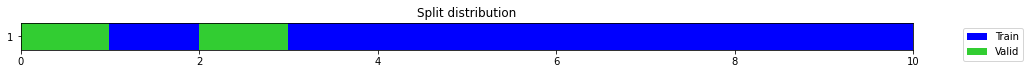

TSTensor(samples:8, vars:3, len:5000, device=cpu)

In [ ]:
from tsai.data.validation import get_splits
from tsai.data.core import get_ts_dls
X = np.zeros((10, 3, 5000)) 
y = np.random.randint(0,2,X.shape[0])
splits = get_splits(y)
dls = get_ts_dls(X, y, splits=splits)
xb, yb = dls.train.one_batch()
xb

If you try to use TSiTPlus, it's likely you'll get an 'out-of-memory' error.

To avoid this you can subsample the sequence reducing the input's length. This can be done in multiple ways. Here are a few examples: 

In [ ]:
# Separable convolution (to avoid mixing channels)
feature_extractor = Conv1d(xb.shape[1], xb.shape[1], ks=100, stride=50, padding=0, groups=xb.shape[1]).to(default_device())
feature_extractor(xb).shape

torch.Size([8, 3, 99])

In [ ]:
# Convolution (if you want to mix channels or change number of channels)
feature_extractor = Conv1d(xb.shape[1], 2, ks=100, stride=50, padding=0).to(default_device())
feature_extractor(xb).shape

torch.Size([8, 2, 99])

In [ ]:
# MaxPool
feature_extractor = nn.Sequential(Pad1d((0, 50), 0), nn.MaxPool1d(kernel_size=100, stride=50)).to(default_device())
feature_extractor(xb).shape

torch.Size([8, 3, 100])

In [ ]:
# AvgPool
feature_extractor = nn.Sequential(Pad1d((0, 50), 0), nn.AvgPool1d(kernel_size=100, stride=50)).to(default_device())
feature_extractor(xb).shape

torch.Size([8, 3, 100])

Once you decide what type of transform you want to apply, you just need to pass the layer as the feature_extractor attribute:

In [ ]:
bs = 16
nvars = 4
seq_len = 1000
c_out = 2
d_model = 128

xb = torch.rand(bs, nvars, seq_len)
feature_extractor = partial(Conv1d, ks=5, stride=3, padding=0, groups=xb.shape[1])
model = TSiTPlus(nvars, c_out, seq_len, d_model=d_model, feature_extractor=feature_extractor)
test_eq(model(xb).shape, (bs, c_out))

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);

<IPython.core.display.Javascript object>

124_models.TSiTPlus.ipynb saved at 2021-11-26 11:28:38.
Converted 124_models.TSiTPlus.ipynb.


Correct conversion! 😃
Total time elapsed 0.095 s
Friday 26/11/21 11:28:41 CET
